# Kaggle Competition Ames Housing Prices: Team Integreat

In [1]:
import pandas as pd
import numpy as np
import plotly
import plotly.plotly as py
from scipy import stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Load and combine test and train

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

# Now drop the 'Id' colum since we can not use it as a feature to train our model.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

#Y_train = train['SalePrice']
#X_train = train.drop('SalePrice', axis=1)
#X_test = test.copy()
target = ['SalePrice']

all_data = pd.concat([train, test], ignore_index=True)
all_data.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,NaN,3,1Fam,TA,No,706.0,0.0,...,WD,0,Pave,8,856.0,AllPub,0,2003,2003,2008
1,1262,0,0,NaN,3,1Fam,TA,Gd,978.0,0.0,...,WD,0,Pave,6,1262.0,AllPub,298,1976,1976,2007
2,920,866,0,NaN,3,1Fam,TA,Mn,486.0,0.0,...,WD,0,Pave,6,920.0,AllPub,0,2001,2002,2008
3,961,756,0,NaN,3,1Fam,Gd,No,216.0,0.0,...,WD,0,Pave,7,756.0,AllPub,0,1915,1970,2006
4,1145,1053,0,NaN,4,1Fam,TA,Av,655.0,0.0,...,WD,0,Pave,9,1145.0,AllPub,192,2000,2000,2008


** initial EDA**

In [ ]:
#inital EDA
all_data.describe()

#investigate relationships
train.describe().columns
cols = ['LotArea','OverallQual','OverallCond','TotalBsmtSF','GarageArea', 'SalePrice']
sns.pairplot(train[cols], size=2)

#SalePrice right-skewed - log or box cox transformation
#TotalBsmtSF and GarageArea normally distributed

#Correlations SalePrice: TotalBsmtSF, GaraArea, OverallQual
#Multicollinearity: OverallQual and TotalBsmtSF, TotalBsmtSF and GarageArea

In [ ]:
cor = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.5)
heat = sns.heatmap(cor, cbar=True,
                  annot=True,
                  square=True,
                  fmt='.2f',
                  annot_kws={'size':15},
                  yticklabels=cols,
                  xticklabels=cols)

#SalePrice correlate with: GarageArea, TotalSF

In [ ]:
# investigate skewness
plt.rcParams['figure.figsize'] = (20, 20)
x = all_data.skew()
values = x.values
col = x.index
values
#values.plot(kind = "barh")
#plt.title("Skewness of the Continuous Numerical Features in the Data")
#plt.show()

** feature engineering**

In [3]:
from preprocess import impute, dummify, Encoder, Skewness, ordinal

all_data = dummify(all_data) #make dummy variables for missing values
all_data = impute(all_data) # impute missing values
all_data = ordinal(all_data) #encode ordinal variables
all_data = Encoder(all_data) # encode categorical variables
all_data = Skewness(all_data) # fix skewness of selected variables
all_data.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,BsmtFullBath_NA,BsmtHalfBath_NA,GarageYrBlt_NA,GarageCars_NA,GarageArea_NA,TotalPorchSF,TotalSF,TotalBath,MSZoning * Neighborhood,BsmtUnfSF / TotalBsmtSF
0,856,854,0,1,3,0,0,3,6.561031,0.0,...,0,0,0,0,0,4.127134,7.850493,4.0,12,0.175234
1,1262,0,0,1,3,0,0,1,6.886532,0.0,...,0,0,0,0,0,5.700444,7.833996,3.0,30,0.225040
2,920,866,0,1,3,0,0,2,6.188264,0.0,...,0,0,0,0,0,3.761200,7.903596,4.0,12,0.471739
3,961,756,0,1,3,0,0,3,5.379897,0.0,...,0,0,0,0,0,5.730100,7.813592,2.0,13,0.714286
4,1145,1053,0,1,4,0,0,0,6.486161,0.0,...,0,0,0,0,0,5.624018,8.114923,4.0,21,0.427948


**split dataset again**

In [78]:
# split dataset
all_data = all_data.copy()
trainset = len(train)
train = all_data[:trainset]
test = all_data[trainset:]

In [79]:
from preprocess import Scaler
train, test = Scaler(train, test)

In [80]:
import random
features = list(set(list(all_data.columns))-set(target))
#Y_train = np.log1p(train['SalePrice'])
#X_train = train[list(features)]
#X_test = test[list(features)]

#if validation within test set is wanted
train = train.copy()
random.seed(10)
train['is_train'] = np.random.uniform(0, 1, len(train)) <= .75
Train, Validate = train[train['is_train']==True], train[train['is_train']==False]

x_train = Train[list(features)].values
y_train = np.log1p(Train["SalePrice"].values)

x_validate = Validate[list(features)].values
y_validate = np.log1p(Validate["SalePrice"].values)

x_test=test[list(features)].values

## **Models**

**simple models**

In [ ]:
#linear regression
from sklearn.linear_model import LinearRegression
linear = LinearRegression()

linear.fit(X_train, Y_train)
linear.score(X_train, Y_train)

pred = linear.predict(X_test)

submission = pd.DataFrame({'Id': test_ID, 'SalePrice': pred})
submission.to_csv('linear_no1.csv', index=False)

In [ ]:
#ElasticNet
from sklearn.linear_model import ElasticNet
elastic = ElasticNet(alpha = 1, l1_ratio = 0.5)

elastic.fit(X_train, Y_train)
elastic.score(X_train, Y_train)

pred = elastic.predict(X_test)

submission = pd.DataFrame({'Id': test_ID, 'SalePrice': pred})
submission.to_csv('elastic_no1.csv', index=False)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

lasso_reg = Lasso(alpha=0.001, tol=0.01, random_state=1)

Lasso_linear = make_pipeline(SelectFromModel(lasso_reg, prefit=False, threshold=None), LinearRegression())

Lasso_linear.fit(X_train, Y_train)
pred = Lasso_linear.predict(X_test)

print('The R^2 is:', Lasso_linear.score(X_train, Y_train))
print('CV score is:',np.mean(cross_val_score(estimator = Lasso_linear, X = X_train, y = Y_train, cv=10, n_jobs=-1)))
print('The RMSE is:', rmse(Y_train, pred))

sns.regplot(Y_train, pred, fit_reg=True, color='red')

#change Y_train_preprocessed to Y_test_preprocessed for final prediction and reverse the log
final_status = np.expm1(Lasso_linear.predict(X_test_preprocessed))
submission = pd.DataFrame({'Id': test_ID, 'SalePrice':final_status})
submission.to_csv('lass0_linear.csv', index=False)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

Scaler_PCA_linear = make_pipeline(PCA(n_components = 59), LinearRegression())

Scaler_PCA_linear.fit(X_train, Y_train)
Scaler_PCA_linear.score(X_train, Y_train)

In [ ]:
# DecisionTree
from  sklearn.treesklearn  import DecisionTreeRegressor

tree = DecisionTreeRegressor()
tree.fit(X_train, Y_train)
tree.score(X_train, Y_train)

pred = np.expm1(tree.predict(X_test))

submission = pd.DataFrame({'Id': test_ID, 'SalePrice':pred})
submission.to_csv('tree.csv', index=False)

In [ ]:
# import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

feat_labels = X_train.columns[0:]

forest = RandomForestClassifier(n_estimators = 500, random_state=1)
forest.fit(X_train, Y_train)

#save values of importance and indices of the columns
importances = forest.feature_importances_
indices = np.argsort(importances)
indices

# print the columns and importance
for feature in range(X_train_std.shape[1]):
    print("%2d) %-*s %feature" % (feature + 1, 30, feat_labels[indices[feature]],
                                 importances[indices[feature]]))
    
#visualize result with all columns
from matplotlib import cm
color = cm.inferno_r(np.linspace(.4,.8, 69))

plt.figure(figsize=(20,20))
plt.title('Feature Importance')

x = plt.barh(range(X_train_std.shape[1]), importances[indices], align='center', color=color)
x = plt.yticks(range(X_train_std.shape[1]), feat_labels, rotation = 0, size=12)
x = plt.ylim([-1, X_train_std.shape[1]])

# set threshold as mean to pick features
from sklearn.feature_selection import SelectFromModel
importances2 = forest.feature_importances_
indices2 = np.argsort(importances2)[::-1]

sfm = SelectFromModel(forest, prefit=True, threshold=None)
X_selected = sfm.transform(X_train_std)


for feature in range(X_selected.shape[1]):
    print("%2d) %-*s %f" % (feature + 1, 30, feat_labels[indices2[feature]],
                                 importances2[indices2[feature]]))
    
#plt.figure(figsize=(20,20))
#plt.title('Feature Importance')

#x = plt.barh(range(X_selected.shape[1]), importances[indices], align='center', color=color)
#x = plt.yticks(range(X_selected.shape[1]), feat_labels, rotation = 0, size=15)

In [ ]:
#Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import make_pipeline

pipe_tree = make_pipeline(SelectFromModel(elastic, prefit=False, threshold=None),svm())
pipe_tree.fit(X_train, Y_train)
pipe_tree.score(X_train, Y_train)

pred = pipe_tree.predict(X_test)

submission = pd.DataFrame({'Id': test_ID, 'SalePrice':pred})
submission.to_csv('elastic_svm.csv', index=False)

## **GridSearch with RF and Boost models**

In [ ]:
from models import modelfitRF
from sklearn.ensemble import RandomForestRegressor

In [ ]:
rf = RandomForestRegressor(n_estimators=500, random_state=1, oob_score=True, n_jobs=-1)

modelfirRF(rf, X_train, features)

In [ ]:
#tuning n_estimators
param_test1 = {'n_estimators':[50,70,80,90,100,200,500,1000]}
gsearch1 = GridSearchCV(estimator = RandomForestRegressor(oob_score=True),
                        param_grid = param_test1,n_jobs=-1,iid=False, cv=5)

gsearch1.fit(X_train,Y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

In [ ]:
rf1 = RandomForestRegressor(oob_score=True, n_estimators=100)

modelfitRF(rf1, X_train, features)

In [ ]:
# tuning max_depth
param_test2 = {'max_depth':[3,5,7,9]}

gsearch2 = GridSearchCV(estimator = RandomForestRegressor(oob_score=True, n_estimators = 100),
                        param_grid = param_test2, n_jobs=-1,iid=False, cv=5)

gsearch2.fit(X_train,Y_train)
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

In [ ]:
#zooming into max_depth
param_test3 = {'max_depth':[8,9,10,11,12,15]}

gsearch3 = GridSearchCV(estimator = RandomForestRegressor(oob_score=True, n_estimators = 100),
                        param_grid = param_test3, n_jobs=-1,iid=False, cv=5)

gsearch3.fit(X_train,Y_train)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

In [ ]:
# tuning min_samples_leaf and min_samples_size
param_test4 = {'min_samples_split':[2,10,30,50],
               'min_samples_leaf':[20,50,10,200,400]}
                                    
gsearch4 = GridSearchCV(estimator = RandomForestRegressor(oob_score=True, n_estimators = 100, max_depth=10),
                        param_grid = param_test4, n_jobs=-1,iid=False, cv=5)

gsearch4.fit(X_train,Y_train)
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_                                    

In [ ]:
modelfitRF(gsearch4.best_estimator_, X_train, features)

In [ ]:
# tuning max_features
param_test5 = {'max_features':[10,20,30,40,50,60,70,80]}
                                    
gsearch5 = GridSearchCV(estimator = RandomForestRegressor(oob_score=True, n_estimators = 100, max_depth=9,
                                                         min_samples_leaf=10, min_samples_split=10),
                        param_grid = param_test5, n_jobs=-1,iid=False, cv=5)

gsearch5.fit(X_train,Y_train)
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_ 

** final Random Tree**

In [ ]:
RandomForestRegressor(oob_score=True,
                      n_estimators = 100,
                      max_depth=9,
                        max_features=40,
                     min_samples_leaf=10,
                     min_samples_split=10)


modelfitRF(gsearch5.best_estimator_, X_train, features)

## **XGBoost**

In [39]:
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn import metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 4
#from models import modelfitxgb

In [126]:
def modelfitxgb(model, x_train, useTrainCV = True, cv_folds=5, printFeatureImportance=True):
    
    if useTrainCV:
        xgb_param = model.get_xgb_params()
        xgtrain = xgb.DMatrix(x_train, label=y_train)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=model.get_params()['n_estimators'],
                          nfold=cv_folds, early_stopping_rounds=50, metrics = 'rmse')
        model.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    model.fit(x_train, y_train, eval_metric='rmse')
        
    #Predict training set:
    status = model.predict(x_validate)
    #plt.scatter(y_validate, status)
    
    if printFeatureImportance:
        feat_imp = pd.Series(model.feature_importances_, features).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances', color='red')
        plt.ylabel('Feature Importance Score')
    
    #Print model report:
    print ("\nModel Report")
    print ("MSE :",metrics.mean_squared_error(y_validate, status))
    print("Score:" ,model.score(x_validate, y_validate))  


Model Report
MSE : 0.015296198848110731
Score: 0.8948068148149756


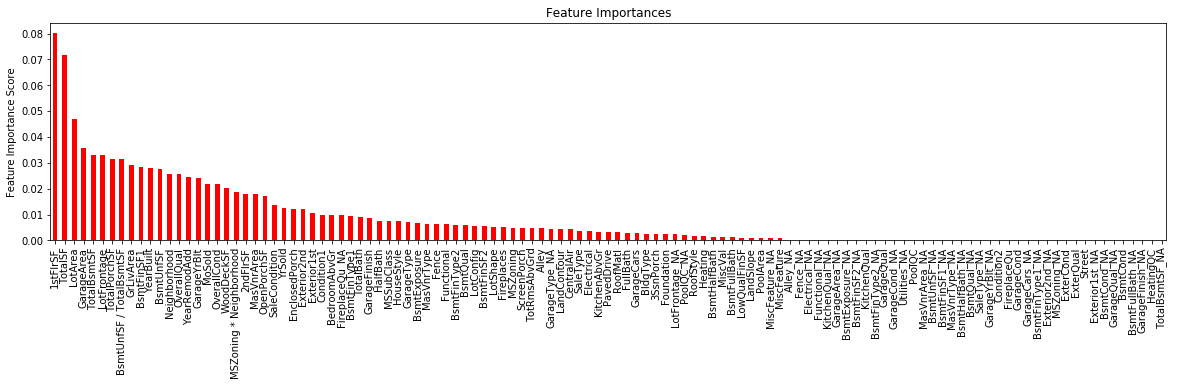

In [127]:
xgb1 = XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'reg:linear',
 n_jobs=-1,
 scale_pos_weight=1,
 seed=27)

modelfitxgb(xgb1, x_train)

In [87]:
#tuning step 1

param_test1 = {
 'max_depth':[3,5,7,9],
 'min_child_weight':[1,3,5]
}
gsearch1 = GridSearchCV(estimator = xgb1,param_grid = param_test1,n_jobs=-1,iid=False, cv=5)
gsearch1.fit(x_train,y_train)

gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.90084, std: 0.01118, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.89483, std: 0.00942, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.89073, std: 0.01177, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.89822, std: 0.00966, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.89707, std: 0.01099, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.89121, std: 0.00929, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.89660, std: 0.00858, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.89329, std: 0.01210, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.89127, std: 0.00649, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.89752, std: 0.00753, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.89143, std: 0.01144, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.89047, std: 0.00976, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 3, 'min_child_weight': 1

In [89]:
#tuning step 2: zooming in

param_test2 = {
 'max_depth':[2,3,4],
 'min_child_weight':[1]
}
gsearch2 = GridSearchCV(estimator = xgb1,param_grid = param_test2,n_jobs=-1,iid=False, cv=5)
gsearch2.fit(x_train,y_train)

gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.89469, std: 0.01201, params: {'max_depth': 2, 'min_child_weight': 1},
  mean: 0.90084, std: 0.01118, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.89839, std: 0.01087, params: {'max_depth': 4, 'min_child_weight': 1}],
 {'max_depth': 3, 'min_child_weight': 1},
 0.9008358647969393)

In [ ]:
#tuning step 2: zooming in

param_test3 = {
 'max_depth':[3],
 'min_child_weight':[4,5,6]
}
gsearch3 = GridSearchCV(estimator = xgb1,param_grid = param_test3,n_jobs=-1,iid=False, cv=5)
gsearch3.fit(X_train,Y_train)

gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

In [91]:
# tuning gamma
param_test4 = {
 'gamma':[i/10.0 for i in range(0,5)]
}

gsearch4 = GridSearchCV(estimator = XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'reg:linear',
 n_jobs=-1,
 scale_pos_weight=1,
 seed=27),param_grid = param_test4,n_jobs=-1,iid=False, cv=5) 
                        
                        
gsearch4.fit(x_train,y_train)
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.90283, std: 0.01031, params: {'gamma': 0.0},
  mean: 0.89581, std: 0.01212, params: {'gamma': 0.1},
  mean: 0.88323, std: 0.01356, params: {'gamma': 0.2},
  mean: 0.87625, std: 0.01343, params: {'gamma': 0.3},
  mean: 0.87183, std: 0.01632, params: {'gamma': 0.4}],
 {'gamma': 0.0},
 0.902832937195701)

In [93]:
xgb2 = XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'reg:linear',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

modelfitxgb(xgb2, x_train)

#max_depth: 3
#min_child_weight: 1
#gamma: 0


Model Report
Error : 0.014003
0.9037021779799362


In [94]:
# tuning subsmaple and colsample
# take values 0.6,0.7,0.8,0.9 for both to start with

param_test5 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

gsearch5 = GridSearchCV(estimator = XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=1,
 gamma=0,
 objective= 'reg:linear',
 n_jobs=-1,
 scale_pos_weight=1,
 seed=27),param_grid = param_test5,n_jobs=-1,iid=False, cv=5) 
                        
                        
gsearch5.fit(x_train,y_train)
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

([mean: 0.90040, std: 0.00921, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: 0.90366, std: 0.01252, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: 0.89741, std: 0.01171, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
  mean: 0.90309, std: 0.00935, params: {'colsample_bytree': 0.6, 'subsample': 0.9},
  mean: 0.90319, std: 0.00653, params: {'colsample_bytree': 0.7, 'subsample': 0.6},
  mean: 0.90117, std: 0.01249, params: {'colsample_bytree': 0.7, 'subsample': 0.7},
  mean: 0.90198, std: 0.01216, params: {'colsample_bytree': 0.7, 'subsample': 0.8},
  mean: 0.90475, std: 0.01083, params: {'colsample_bytree': 0.7, 'subsample': 0.9},
  mean: 0.89814, std: 0.01198, params: {'colsample_bytree': 0.8, 'subsample': 0.6},
  mean: 0.90120, std: 0.01144, params: {'colsample_bytree': 0.8, 'subsample': 0.7},
  mean: 0.90283, std: 0.01031, params: {'colsample_bytree': 0.8, 'subsample': 0.8},
  mean: 0.90132, std: 0.01021, params: {'colsample_bytree': 0.8, 'subsample'

In [95]:
# tuning subsmaple and colsample
# go in 0.05 increments 
param_test6 = {
 'subsample':[i/100.0 for i in range(85,95,5)],
 'colsample_bytree':[i/100.0 for i in range(65,75,5)]
}

gsearch6 = GridSearchCV(estimator = XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'reg:linear',
 n_jobs=-1,
 scale_pos_weight=1,
 seed=27),param_grid = param_test6,n_jobs=-1,iid=False, cv=5) 
                        
                        
%timeit gsearch6.fit(x_train,y_train)
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

12.3 s ± 279 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


([mean: 0.90312, std: 0.01171, params: {'colsample_bytree': 0.65, 'subsample': 0.85},
  mean: 0.90327, std: 0.01305, params: {'colsample_bytree': 0.65, 'subsample': 0.9},
  mean: 0.89937, std: 0.00972, params: {'colsample_bytree': 0.7, 'subsample': 0.85},
  mean: 0.90475, std: 0.01083, params: {'colsample_bytree': 0.7, 'subsample': 0.9}],
 {'colsample_bytree': 0.7, 'subsample': 0.9},
 0.9047464610902216)

In [103]:
param_test7 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch7 = GridSearchCV(estimator = XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=1,
 gamma=0,
 subsample=0.9,
 colsample_bytree=0.7,
 objective= 'reg:linear',
 n_jobs=-1,
 scale_pos_weight=1,
 seed=27),param_grid = param_test7,n_jobs=-1,iid=False, cv=5) 


%timeit gsearch7.fit(x_train,y_train)
gsearch7.grid_scores_, gsearch7.best_params_, gsearch7.best_score_

13 s ± 160 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


([mean: 0.90382, std: 0.01069, params: {'reg_alpha': 1e-05},
  mean: 0.90412, std: 0.00894, params: {'reg_alpha': 0.01},
  mean: 0.89922, std: 0.01195, params: {'reg_alpha': 0.1},
  mean: 0.89712, std: 0.01191, params: {'reg_alpha': 1},
  mean: 0.34266, std: 0.03504, params: {'reg_alpha': 100}],
 {'reg_alpha': 0.01},
 0.9041195476983868)

** final XGBoost**


Model Report
MSE : 0.013622562890901134
Score: 0.9063165434035791


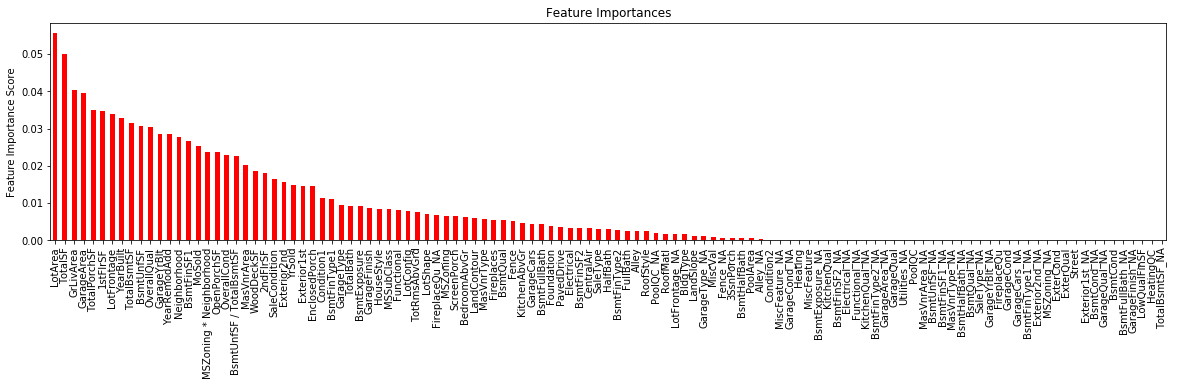

In [128]:
xgb3 = XGBRegressor(
 learning_rate =0.01,
 n_estimators=2000,
 max_depth=5,
 min_child_weight=4,
 gamma=0,
 subsample=0.9,
 colsample_bytree=0.7,
 objective= 'reg:linear',
 nthread=4,
 scale_pos_weight=1,
 reg_alpha=0.01,
 seed=27)

modelfitxgb(xgb3, x_train)

#max_depth: 3
#min_child_weight: 1
#gamma: 0
#subsample=0.9,
#colsample_bytree=0.7,
#reg_alpha=0.01

## **GradientBoost**

In [107]:
from sklearn.ensemble import GradientBoostingRegressor  #GBM algorithm
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid searchc

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 4

#from models import modelfitGB

In [129]:
 def modelfitGB(model, x_train, features, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    model.fit(x_train, y_train)
        
    #Predict training set:
    status = model.predict(x_validate)
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_validation.cross_val_score(model, x_train, y_train, cv=cv_folds, scoring='neg_mean_squared_error')
    
    #Print model report:
    print("\nModel Report")
    print("MSE :", metrics.mean_squared_error(y_validate, status))
    print("Score:", model.score(x_validate, y_validate))
    
    if performCV:
        print ("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(model.feature_importances_, features).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances', color='red')
        plt.ylabel('Feature Importance Score')


Model Report
MSE : 0.014219895183038645
Score: 0.9022086413654478
CV Score : Mean - -0.01740931 | Std - 0.002915079 | Min - -0.02179824 | Max - -0.01391176


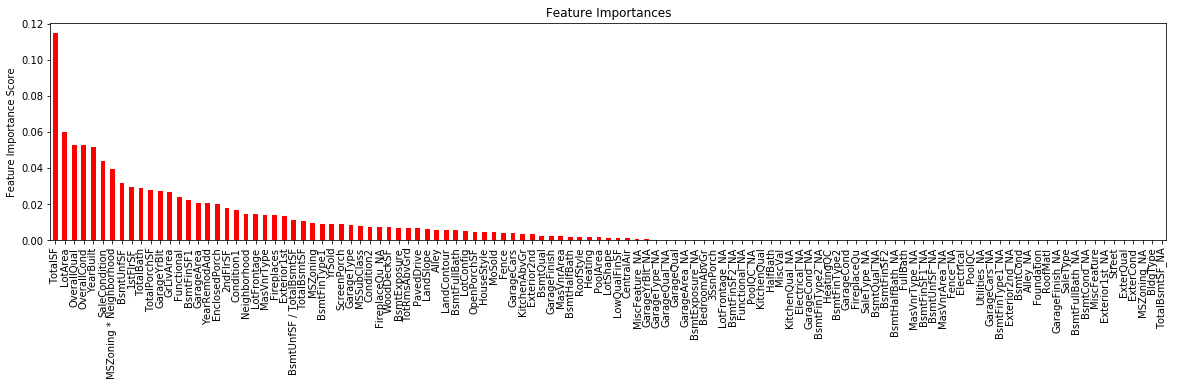

In [130]:
# baseline model

gbm0 = GradientBoostingRegressor(random_state=10)
modelfitGB(gbm0, x_train, features)

In [110]:
# tuning n_estimators
param_test1 = {'n_estimators':[70,80,90,100]}
gsearch1 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.1,
                                                              min_samples_split=500,
                                                              min_samples_leaf=50,
                                                              max_depth=8,
                                                              max_features='sqrt',
                                                              subsample=0.8,
                                                              random_state=10), 
param_grid = param_test1, scoring='neg_mean_squared_error',n_jobs=-1,iid=False, cv=5)
gsearch1.fit(x_train,y_train)

gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: -0.02544, std: 0.00559, params: {'n_estimators': 70},
  mean: -0.02444, std: 0.00515, params: {'n_estimators': 80},
  mean: -0.02347, std: 0.00493, params: {'n_estimators': 90},
  mean: -0.02281, std: 0.00473, params: {'n_estimators': 100}],
 {'n_estimators': 100},
 -0.02280673362243654)

In [111]:
param_test2 = {'max_depth':[5, 7, 9, 11, 13, 15], 'min_samples_split':[200, 400, 600, 800, 1000]}
gsearch2 = GridSearchCV(estimator = GradientBoostingRegressor(n_estimators=100,
                                                              learning_rate=0.1,
                                                              min_samples_split=500,
                                                              min_samples_leaf=50,
                                                              max_depth=8,
                                                              max_features='sqrt',
                                                              subsample=0.8,
                                                              random_state=10), 
param_grid = param_test2, scoring='neg_mean_squared_error',n_jobs=-1,iid=False, cv=5)

gsearch2.fit(x_train, y_train)
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_


([mean: -0.02057, std: 0.00399, params: {'max_depth': 5, 'min_samples_split': 200},
  mean: -0.02221, std: 0.00476, params: {'max_depth': 5, 'min_samples_split': 400},
  mean: -0.02436, std: 0.00487, params: {'max_depth': 5, 'min_samples_split': 600},
  mean: -0.16455, std: 0.01451, params: {'max_depth': 5, 'min_samples_split': 800},
  mean: -0.16455, std: 0.01451, params: {'max_depth': 5, 'min_samples_split': 1000},
  mean: -0.02075, std: 0.00384, params: {'max_depth': 7, 'min_samples_split': 200},
  mean: -0.02221, std: 0.00477, params: {'max_depth': 7, 'min_samples_split': 400},
  mean: -0.02436, std: 0.00487, params: {'max_depth': 7, 'min_samples_split': 600},
  mean: -0.16455, std: 0.01451, params: {'max_depth': 7, 'min_samples_split': 800},
  mean: -0.16455, std: 0.01451, params: {'max_depth': 7, 'min_samples_split': 1000},
  mean: -0.02067, std: 0.00396, params: {'max_depth': 9, 'min_samples_split': 200},
  mean: -0.02221, std: 0.00477, params: {'max_depth': 9, 'min_samples_spli

In [112]:
param_test3 = {'min_samples_split':[50,150,200,250,300], 'min_samples_leaf':[2,5,10,20,30,40,50,60,70]}

gsearch3 = GridSearchCV(estimator = GradientBoostingRegressor(n_estimators=100,
                                                              learning_rate=0.1,
                                                              min_samples_split=200,
                                                              min_samples_leaf=50,
                                                              max_depth=5,
                                                              max_features='sqrt',
                                                              subsample=0.8,
                                                              random_state=10),
param_grid = param_test3, scoring='neg_mean_squared_error',n_jobs=-1,iid=False, cv=5)
gsearch3.fit(x_train,y_train)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: -0.01722, std: 0.00475, params: {'min_samples_leaf': 2, 'min_samples_split': 50},
  mean: -0.01701, std: 0.00283, params: {'min_samples_leaf': 2, 'min_samples_split': 150},
  mean: -0.01826, std: 0.00314, params: {'min_samples_leaf': 2, 'min_samples_split': 200},
  mean: -0.01916, std: 0.00385, params: {'min_samples_leaf': 2, 'min_samples_split': 250},
  mean: -0.01912, std: 0.00357, params: {'min_samples_leaf': 2, 'min_samples_split': 300},
  mean: -0.01749, std: 0.00272, params: {'min_samples_leaf': 5, 'min_samples_split': 50},
  mean: -0.01810, std: 0.00269, params: {'min_samples_leaf': 5, 'min_samples_split': 150},
  mean: -0.01888, std: 0.00317, params: {'min_samples_leaf': 5, 'min_samples_split': 200},
  mean: -0.01921, std: 0.00330, params: {'min_samples_leaf': 5, 'min_samples_split': 250},
  mean: -0.01925, std: 0.00332, params: {'min_samples_leaf': 5, 'min_samples_split': 300},
  mean: -0.01804, std: 0.00268, params: {'min_samples_leaf': 10, 'min_samples_split': 50},
 


Model Report
Error : 0.013818
0.904973533431504
CV Score : Mean - -0.01700647 | Std - 0.002826864 | Min - -0.02033566 | Max - -0.01183848


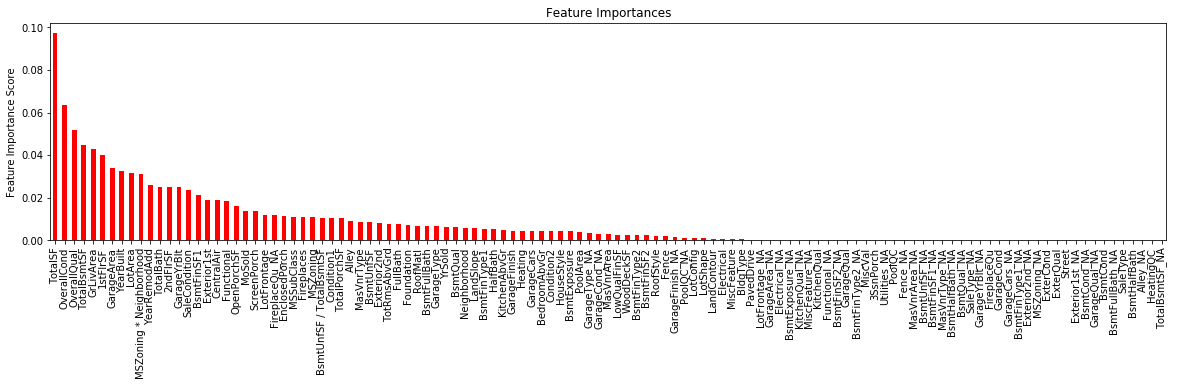

In [113]:
modelfitGB(gsearch3.best_estimator_, x_train, features)

In [114]:
param_test4 = {'max_features':[5, 10,20,30,40,50,60,70,80]}

gsearch4 = GridSearchCV(estimator = GradientBoostingRegressor(n_estimators=100,
                                                              learning_rate=0.1,
                                                              min_samples_split=150,
                                                              min_samples_leaf=2,
                                                              max_depth=5,
                                                              max_features='sqrt',
                                                              subsample=0.8,
                                                              random_state=10),
param_grid = param_test4, scoring='neg_mean_squared_error',n_jobs=-1,iid=False, cv=5)
gsearch4.fit(x_train,y_train)
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

#n_estimators=100
#min_samples_split: 150
#min_samples_leaf: 2
#max_depth: 5
#max_features: 40

([mean: -0.01839, std: 0.00309, params: {'max_features': 5},
  mean: -0.01701, std: 0.00283, params: {'max_features': 10},
  mean: -0.01760, std: 0.00274, params: {'max_features': 20},
  mean: -0.01708, std: 0.00183, params: {'max_features': 30},
  mean: -0.01767, std: 0.00262, params: {'max_features': 40},
  mean: -0.01797, std: 0.00320, params: {'max_features': 50},
  mean: -0.01736, std: 0.00256, params: {'max_features': 60},
  mean: -0.01786, std: 0.00290, params: {'max_features': 70},
  mean: -0.01745, std: 0.00250, params: {'max_features': 80}],
 {'max_features': 10},
 -0.017006473088538088)

In [115]:
param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}

gsearch5 = GridSearchCV(estimator = GradientBoostingRegressor(n_estimators=100,
                                                              learning_rate=0.1,
                                                              min_samples_split=150,
                                                              min_samples_leaf=2,
                                                              max_depth=5,
                                                              max_features=10,
                                                              subsample=0.8,
                                                              random_state=10),
param_grid = param_test5, scoring='neg_mean_squared_error',n_jobs=-1,iid=False, cv=5)

gsearch5.fit(x_train,y_train)
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

([mean: -0.01769, std: 0.00320, params: {'subsample': 0.6},
  mean: -0.01785, std: 0.00332, params: {'subsample': 0.7},
  mean: -0.01822, std: 0.00330, params: {'subsample': 0.75},
  mean: -0.01701, std: 0.00283, params: {'subsample': 0.8},
  mean: -0.01767, std: 0.00296, params: {'subsample': 0.85},
  mean: -0.01809, std: 0.00241, params: {'subsample': 0.9}],
 {'subsample': 0.8},
 -0.017006473088538088)


Model Report
Error : 0.013818
0.904973533431504
CV Score : Mean - -0.01700647 | Std - 0.002826864 | Min - -0.02033566 | Max - -0.01183848


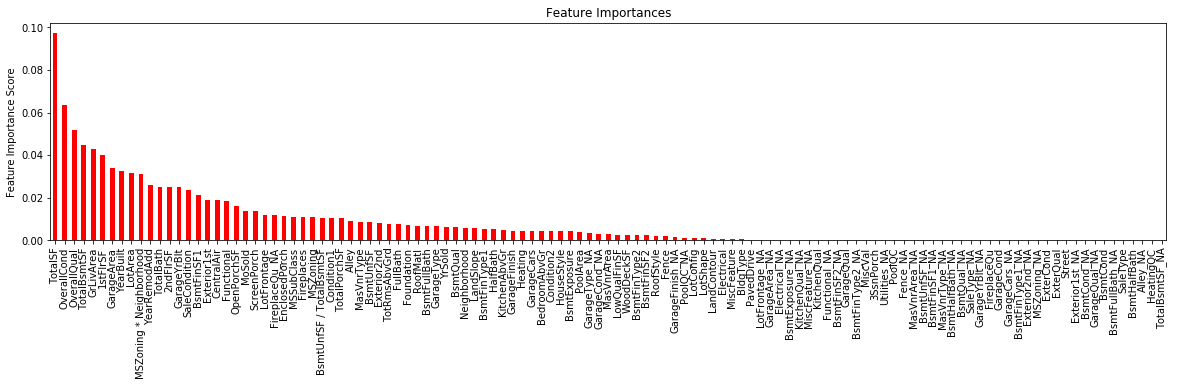

In [120]:
gbm_tuned_1 = GradientBoostingRegressor(n_estimators=100,
                                                              learning_rate=0.1,
                                                              min_samples_split=150,
                                                              min_samples_leaf=2,
                                                              max_depth=5,
                                                              max_features=10,
                                                              subsample=0.8,
                                                              random_state=10)
modelfitGB(gbm_tuned_1, x_train, features)


Model Report
Error : 0.013636
0.9062265007731317
CV Score : Mean - -0.01668231 | Std - 0.002445098 | Min - -0.01858632 | Max - -0.01192833


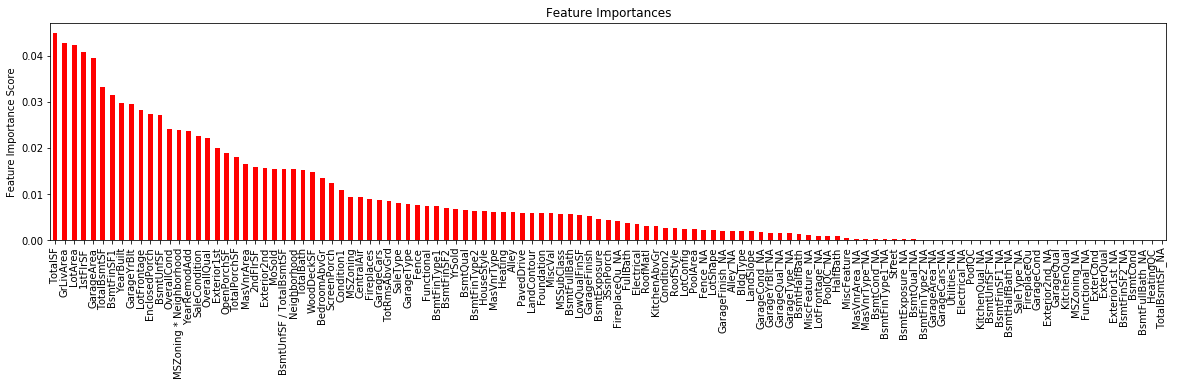

In [123]:
gbm_tuned_3 = GradientBoostingRegressor(n_estimators=1000,
                                                              learning_rate=0.05,
                                                              min_samples_split=150,
                                                              min_samples_leaf=2,
                                                              max_depth=5,
                                                              max_features=10,
                                                              subsample=0.8,
                                                              random_state=10)
modelfitGB(gbm_tuned_3, x_train, features)

** final GradientBoost**


Model Report
MSE : 0.013235267684198979
Score: 0.9089800035745956
CV Score : Mean - -0.01607909 | Std - 0.00261392 | Min - -0.01861569 | Max - -0.01106235


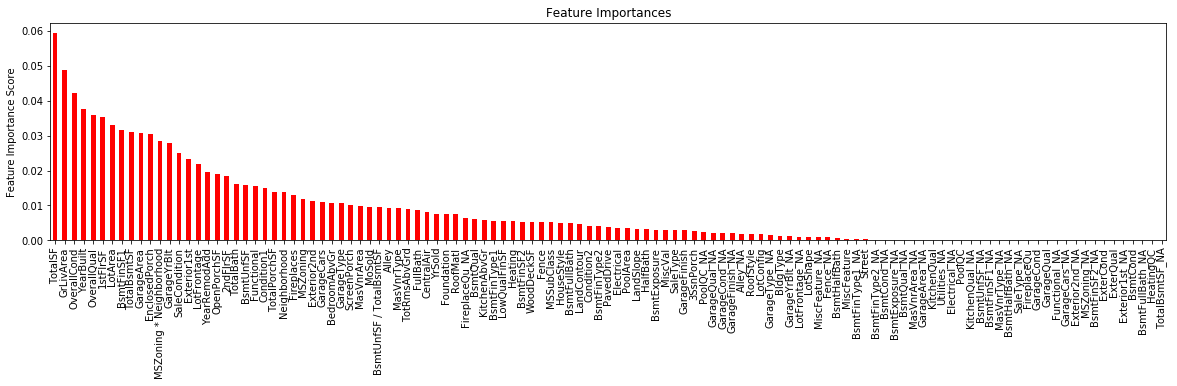

In [131]:
gbm_tuned_2 = GradientBoostingRegressor(n_estimators=2000,
                                                              learning_rate=0.01,
                                                              min_samples_split=150,
                                                              min_samples_leaf=2,
                                                              max_depth=5,
                                                              max_features=10,
                                                              subsample=0.8,
                                                              random_state=10)
modelfitGB(gbm_tuned_2, x_train, features)

In [ ]:
#wasnt able to intall Light GBM
import lightgbm as lgb

train_data=lgb.Dataset(x_train,label=y_train)
params = {'learning_rate':0.001}
model= lgb.train(params, train_data, 100)
from sklearn.metrics import mean_squared_error
rmse=mean_squared_error(y_pred,y_test)**0.5

## KNN

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from models import modelfitKNN

In [ ]:
knn = KNeighborsRegressor()

modelfitKNN(knn, X_train)

In [ ]:
param_test1 = { 'n_neighbors': [3, 5, 7, 9,11,13,17],
                'weights' : ['uniform','distance']}

gsearch1 = GridSearchCV(estimator = KNeighborsRegressor(),
                        param_grid = param_test1,n_jobs=-1,iid=False, cv=5)


gsearch1.fit(X_train,Y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

## **Stacking**

In [ ]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.base import clone

def stacking_regression(models, meta_model, X_train, y_train, X_test,
             transform_target=None, transform_pred=None,
             metric=None, n_folds=3, average_fold=True,
             shuffle=False, random_state=0, verbose=1):
   
    if verbose > 0:
        print('metric: [%s]\n' % metric.__name__)

    # Split indices to get folds
    kf = KFold(n_splits = n_folds, shuffle = shuffle, random_state = random_state)

    if X_train.__class__.__name__ == "DataFrame":
    	X_train = X_train.as_matrix()
    	X_test = X_test.as_matrix()

    # Create empty numpy arrays for stacking features
    S_train = np.zeros((X_train.shape[0], len(models)))
    S_test = np.zeros((X_test.shape[0], len(models)))

    # Loop across models
    for model_counter, model in enumerate(models):
        if verbose > 0:
            print('model %d: [%s]' % (model_counter, model.__class__.__name__))

        # Create empty numpy array, which will contain temporary predictions for test set made in each fold
        S_test_temp = np.zeros((X_test.shape[0], n_folds))
        # Loop across folds
        for fold_counter, (tr_index, te_index) in enumerate(kf.split(X_train, y_train)):
            X_tr = X_train[tr_index]
            y_tr = y_train[tr_index]
            X_te = X_train[te_index]
            y_te = y_train[te_index]
            
            # Clone the model because fit will mutate the model.
            instance = clone(model)
            
            # Fit 1-st level model
            instance.fit(X_tr, transformer(y_tr, func = transform_target))
            
            # Predict out-of-fold part of train set
            S_train[te_index, model_counter] = transformer(instance.predict(X_te), func = transform_pred)
            
            # Predict full test set
            S_test_temp[:, fold_counter] = transformer(instance.predict(X_test), func = transform_pred)

            # Delete temperatory model
            del instance

            if verbose > 1:
                print('    fold %d: [%.8f]' % (fold_counter, metric(y_te, S_train[te_index, model_counter])))

        # Compute mean or mode of predictions for test set
        if average_fold:
            S_test[:, model_counter] = np.mean(S_test_temp, axis = 1)
        else:
            model.fit(X_train, transformer(y_train, func = transform_target))
            S_test[:, model_counter] = transformer(model.predict(X_test), func = transform_pred)

        if verbose > 0:
            print('    ----')
            print('    MEAN:   [%.8f]\n' % (metric(y_train, S_train[:, model_counter])))

    # Fit our second layer meta model
    
    meta_model.fit(S_train, transformer(y_train, func = transform_target))
    
    # Make our final prediction
    stacking_prediction = transformer(meta_model.predict(S_test), func = transform_pred)

    return stacking_prediction

In [ ]:
models = [
    # KNN
    
    # RandomForest
    #RandomForestRegressor(oob_score=True,
    #                      n_estimators = 500,
    #                      max_depth=12,
    #                      max_features=40,
    #                      min_sample_split=3),
    
    # XGBoost
    XGBRegressor(learning_rate =0.1,
                 n_estimators=1000,
                 max_depth=5,
                 min_child_weight=4,
                 gamma=0,
                 subsample=0.8,
                 colsample_bytree=0.55,
                 objective= 'reg:linear',
                 nthread=4,
                 scale_pos_weight=1,
                 reg_alpha=0.01,
                 seed=27),
    
    # GradientBoost
    GradientBoostingRegressor(n_estimators=200,
                             learning_rate=0.05,
                             min_samples_split=150,
                             min_samples_leaf=2,
                             max_depth=7,
                              max_features=9,
                             subsample=0.8,
                             random_state=10),
    
    # Light GBoost
    #gbr(random_state = 0, learning_rate = 0.01, max_features='sqrt',
    #    min_samples_leaf=10, min_samples_split=5, 
    #    n_estimators = 1000, max_depth = 9)
    ]

meta_model = LinearRegression(normalize=True)

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def rmse(Y_train, Y_pred):
    rmse = sqrt(mean_squared_error(Y_train, Y_pred))
    
    return rmse

def rmse_cv(X_train_preprocessed, Y_train):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring = 'neg_mean_squared_error', cv = 5))
    return rmse

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [ ]:
%%time
final_prediction = stacking_regression(models, meta_model, X_train, Y_train, X_test,
                               transform_target=None, transform_pred = np.expm1, 
                               metric=rmsle, verbose=1)

In [ ]:
submission = pd.DataFrame({'Id': test_ID, 'SalePrice':final_prediction})
submission.to_csv('stack.csv', index=False)